<a href="https://colab.research.google.com/github/seongheechoi/education/blob/main/2_RL_AI_gym_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OutLine

1.   Frozen Lake 환경 설정

2.   Q-table 작성, Q-러닝 알고리즘 작성

3. Exploration 방법 설정


> * Random Noise
* Epsilon-greedy



4. SARSA

> * Random Noise
* Epsilon-greedy

5. 실험 환경 변경

> * Hole 위치 및 시작,목적지 변경
* 8x8 크기의 Frozen Lake 설정

6. 실험 변경(Taxi Environment)

# Q-러닝을 이용한 게임 실습(Frozen lake)

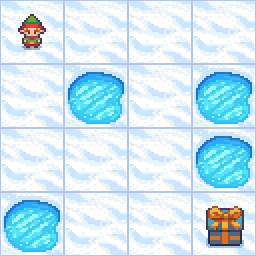

Frozen lake는 시작 지점과 도착 지점이 정해진 환경에서, 빙판길에 존재하는 구멍(Hole)을 피해 목적지에 도착하는 환경.
<br>
**상태: 4x4 = 16**
<br>
**행동: 상하좌우 = 4**
<br>
**보상: 목적지에 도착하는 경우 1, 나머지의 경우 모두 0**
<br>
**환경은 목적지에 도착하거나, 구멍에 빠지는 경우 에피소드 종료**

상태-행동 가치 함수인 Q값을 업데이트 하고, 이에 따라 정책을 업데이트 하는 예제 실습<br>
이 때  Q값을 저장하는 Q-table은 상태x행동 = 16x4 = 64의 크기를 가지는 행렬로 표현 가능

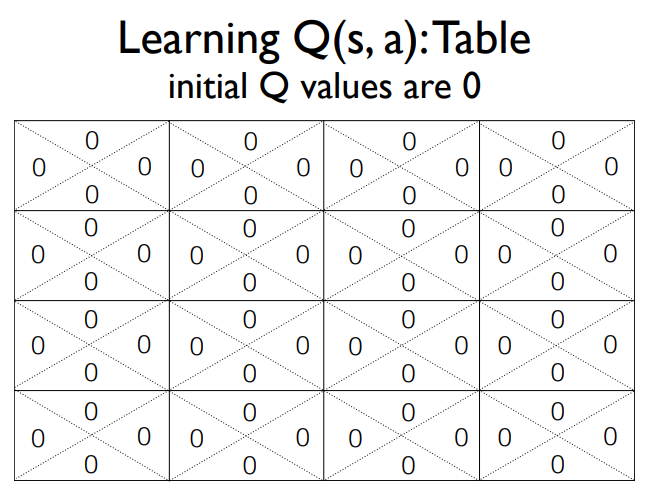

모든 Q값의 업데이트는 반드시 모든 state를 충분히 탐험해 보았음을 전제로 함.
<br>따라서 단순히 현재 최대값을 활용하는 방법이 아닌, 탐험을 진행하도록 action을 선택하는 방법이 필요.

# 1. random noise 방식

현재 state에서 가능한 action에 따른 Q값(총 4가지)에 random noise를 주어서, 이 것이 최대값이 되는 action을 선택.<br> noise가 Q값보다 큰 경우, Q값을 최대화 하는 action 대신 다른 action을 선택.<br> **처음엔 높은 noise 값을 주고, 학습이 진행됨에 따라 Q값이 안정화 되면 noise를 줄여가며 exploitation 위주의 학습 진행.**


In [ ]:
! pip install gym==0.15.3
!pip uninstall numpy
!pip install numpy==1.23.5
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 whic

Found existing installation: numpy 2.3.2
Uninstalling numpy-2.3.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.3.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-8fb3d286.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? ERROR: Operation cancelled by user
^C
^C


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register

In [ ]:
#학습 환경과 Q-table을 입력
def simulate_policy(env, Q):
    state = env.reset()
    done = False

    while not done:
        action = np.argmax(Q[state, :]) #행동은 Q-table에서 가장 큰 Q값을 가지는 행동을 선택
        new_state, _, done, _ = env.step(action)  #환경에서 action을 취했을 때 다음 상태, 보상, 종료 여부 등의 정보를 반환
        env.render()                              #현재 상태를 가시적으로 보임
        state = new_state                         #상태를 변경하고, 에피소드가 끝날 때 까지 반복

In [ ]:
#register는 실험 환경에 대한 세팅으로, register를 수정함으로써 학습하려는 환경의 설정을 변경 가능
register(
    id='FrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False}           #map의 크기는 4x4, 미끄러지지 않도록 설정
)

In [ ]:
env = gym.make('FrozenLake-v1')

# Q Table을 초기화
Q = np.zeros([env.observation_space.n, env.action_space.n])

discount_factor = 0.99
alpha = 0.9
num_episodes = 2000           #감쇄율과 Q값이 업데이트 되는 정도인 alpha, 에피소드 수를 결정

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()   #환경을 초기화
    reward_sum = 0
    done = False
    first = False
    while not done:   #환경이 종료될 때 까지 반복적으로 학습


        #Action을 선택할 때, 기존에 존재하던 Q값에 random한 noise값을 추가한 값 중 가장 큰 값을 선택
        #이 때, Random noise값은 매 학습이 진행될수록 감소하도록 설계
        action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n) / (i + 1))

        #선택된 Action을 실행하고, 다음 State와 보상에 대한 정보를 받음
        new_state, reward, done, _ = env.step(action)

        #행동을 통해 얻은 값을 바탕으로, Q Table을 갱신
        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state]) - Q[state, action])

        #보상합과 State를 재설정
        reward_sum += reward
        state = new_state

    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))


학습 이 끝난 이후 환경의 에피소드 성공률과 최종 Q-table 출력
<br> 이 때, state의 순서는 좌측 상단부터 오른쪽으로 진행
<br> 즉, 15번째 항은 목적지 직전의 state를 의미

In [ ]:
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.884
Final Q-Table Values
[[0.         0.         0.95099005 0.        ]
 [0.         0.         0.96059601 0.        ]
 [0.         0.970299   0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.99       0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]]


다음으로, 에피소드 별 학습 성공.실패 그래프 출력<br>
처음에 보상을 얻는 데 성공하여도 Random Noise의 값이 큰 경우
가치 함수 값보다 Noise값이 커서 탐험 진행 가능<br>
이후 Noise값이 충분히 줄어들면 활용을 통해 가치함수와 정책 업데이트

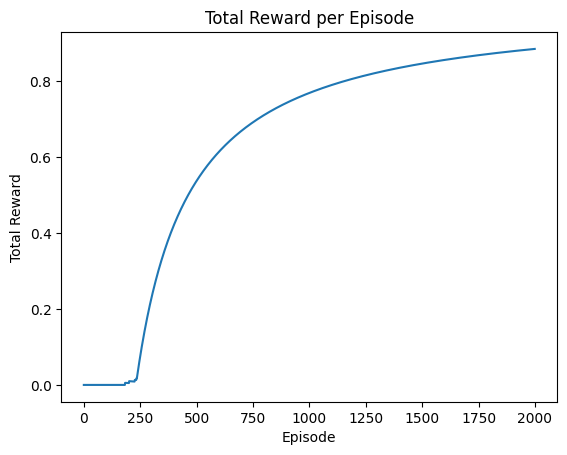

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
# plt.plot(range(1, num_episodes + 1), total_reward_sum, color="blue", s=5)
# plt.scatter(range(1, num_episodes + 1), total_reward_sum, color="blue", s=5)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

학습된 정책을 이용해 환경의 에피소드 예시를 확인

In [ ]:
simulate_policy(env, Q)

print("Simulation complete.")

env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Simulation complete.


#2. E-greedy 방식
E-Greedy 방식은 어떠한 확률값 e를 주어, e의 확률로 탐험 진행<br> 예를 들어 e=0.99 이면 99%의 확률로 기존의 정보를 활용하고, 1%의 확률로 탐험을 진행<br> Random Noise 방법과 마찬가지로 학습이 진행될수록 탐험 확률을 낮추도록 작성

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr

env = gym.make('FrozenLake-v1')

# Q Table
Q = np.zeros([env.observation_space.n, env.action_space.n])

discount_factor = 0.99
num_episodes = 2000
alpha = 0.9

total_reward = []
total_reward_sum = []
for i in range(num_episodes):

    state = env.reset()
    reward_sum = 0
    done = False

    #학습이 진행될수록 점점 줄어드는 epsilon 값을 정의
    e = 1. / ((i // 100) + 1)

    while not done:
        #epsilon의 확률로 무작위 행동을 선택
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        #이외의 경우엔 Q값을 따라가도록 행동을 선택
        else:
            action = np.argmax(Q[state, :])
        new_state, reward, done, _ = env.step(action)

        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state]) - Q[state, action])

        reward_sum += reward
        state = new_state

    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))

In [ ]:
#성공률과 Q-table 값
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.8075
Final Q-Table Values
[[0.94148015 0.95099005 0.93206535 0.94148015]
 [0.94148015 0.         0.7474232  0.93206535]
 [0.92274469 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.95099005 0.96059601 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9800902  0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.96059601 0.         0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.        ]
 [0.970299   0.99       0.         0.97009627]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.99       0.970299  ]
 [0.9801     0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]


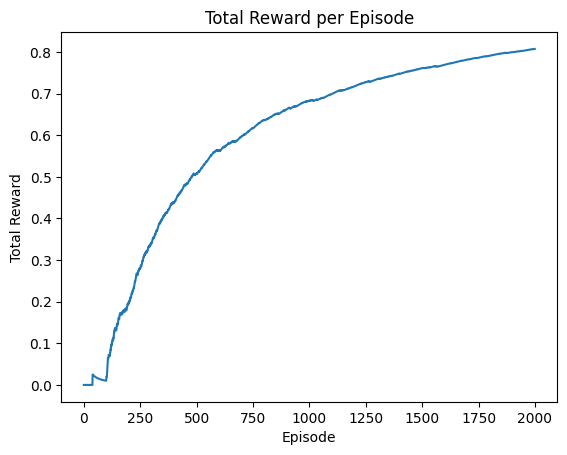

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

탐험을 통해 충분히 Q-table 값을 업데이트 했다면 탐험 확률을 낮출 필요가 있음을 확인 가능

In [ ]:
#좌표 (4,3), 목적지 직전 상태에서 수행하는 최적 행동 확인
print("What is the best move when i'm on 15?")
my_Action = np.argmax(Q[14])

if my_Action==0:
  print("Left")

elif my_Action==1:
  print("Down")

elif my_Action==2:
  print("Right")

else: print("up")

simulate_policy(env, Q)

What is the best move when i'm on 15?
Right
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


# Stochastic 환경에서의 Q-러닝

미끄러운 빙판길에서는 원하는 방향으로 가지 않고, 미끄러질 수 있음.
<br>
즉, 똑같은 행동을 하더라도 확률적으로 다른 상태에 도달 가능.
<br><br>
**Q-Learning 방법이 Stochastic 환경에서도 학습 가능한지 실습**

In [ ]:
register(
    id='FrozenLake-v2',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': True}      #이번엔 빙판길 위에서 미끄러질 수 있는 가능성을 생각하여 환경을 설정
)

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr

env = gym.make("FrozenLake-v2", is_slippery=True)
env.reset()

Q = np.zeros((env.observation_space.n, env.action_space.n))

num_episodes= 2000
alpha = 0.9
discount_factor = 0.9

epsilon = 1.0
epsilon_decay = 0.001   #이번엔 epsilon 값의 감소 방법을 일정하게 정한 scale만큼 지속적으로 감소시키도록 진행

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()
    reward_sum = 0
    done = False

    while not done:

        if np.random.random(1) < epsilon:
          action = env.action_space.sample()
        else:
          action = np.argmax(Q[state])
        new_state, reward, done, info = env.step(action)

        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state]) - Q[state, action])

        reward_sum += reward
        state = new_state

    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))
    #이번엔 epsilon 값의 감소 방법을 일정하게 정한 scale만큼 지속적으로 감소시키도록 진행
    epsilon = max(epsilon - epsilon_decay, 0)



In [ ]:
#성공률과 Q-table 값
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.3895
Final Q-Table Values
[[1.06373325e-01 3.22562013e-04 3.12263296e-04 2.99493764e-04]
 [5.16109838e-06 5.19276081e-06 6.60784367e-06 1.39144098e-01]
 [2.95553321e-01 1.13938035e-05 9.17134495e-06 1.33367317e-05]
 [2.18081051e-06 1.50122003e-06 1.13315697e-06 1.32856536e-05]
 [3.71272486e-01 2.29285233e-04 1.60589984e-04 7.56760249e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.38691236e-08 3.53900413e-08 1.75266287e-02 2.33633293e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.09379946e-04 3.70352698e-05 1.54164267e-04 6.74916822e-01]
 [7.61984952e-05 8.84805239e-02 1.67378346e-04 3.82306229e-05]
 [7.96304689e-01 5.55031346e-05 5.78983212e-05 5.25655830e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.97934101e-03 7.98674155e-03 6.39314239e-01 2.96448396e-03]
 [1.33576644e-02 9.69786964e-01 3.41816532e-02 1.26169542e-02]
 [0.00000000e

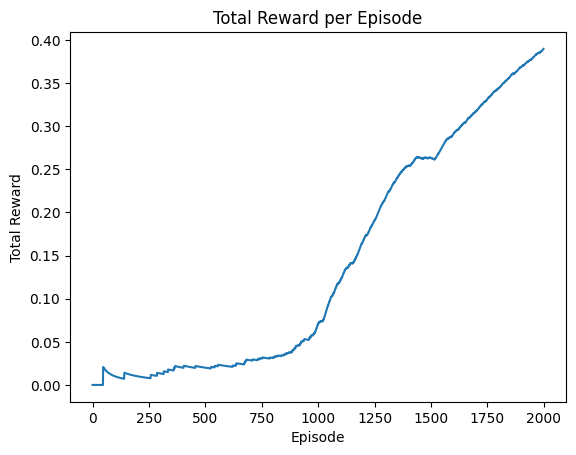

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
#좌표 (4,3), 목적지 직전 상태에서 수행하는 최적 행동 확인
print("What is the best move when i'm on 15?")
my_Action = np.argmax(Q[14])

if my_Action==0:
  print("Left")

elif my_Action==1:
  print("Down")

elif my_Action==2:
  print("Right")

else: print("up")

simulate_policy(env, Q)

What is the best move when i'm on 15?
Down
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (L

# SARSA
이전 실험에서 사용한 방법은, Q-Learning이며, 다음과 같이 표현 가능.
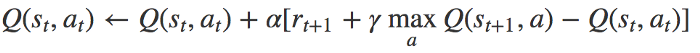
<br> SARSA는 다음과 같은 식을 따르도록 학습<br>
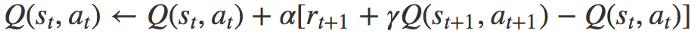

**1.** **Random Noise 방법의 SARSA**

In [ ]:
import gym
from gym import wrappers
import numpy as np

env = gym.make("FrozenLake-v2")

Q = np.zeros([env.observation_space.n, env.action_space.n])

num_episodes = 2000
discount_factor = 0.99
alpha = 0.9

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()
    reward_sum = 0
    done = False
    action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

    while not done:
        new_state, reward, done, _ = env.step(action)
        new_action = np.argmax(Q[new_state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

        #Q 값의 업데이트에서, Q-Learning과 SARSA의 차이가 발생
        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * Q[new_state, new_action] - Q[state, action])
        reward_sum += reward
        state = new_state
        action = new_action
    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))

In [ ]:
#성공률과 Q-table 값
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.3055
Final Q-Table Values
[[8.39671347e-05 3.41224502e-04 6.38462253e-02 1.04604571e-04]
 [5.63342148e-05 1.13842983e-03 2.87606372e-05 3.37716635e-04]
 [3.70835073e-05 1.84327070e-06 3.85956870e-05 3.44434015e-05]
 [8.99305705e-06 4.37951466e-05 3.93773450e-06 3.63427123e-05]
 [7.52691330e-01 1.60815150e-04 1.08273054e-06 1.93263046e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.73497082e-07 2.05086847e-04 1.88542337e-05 1.36414328e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.52817253e-05 3.12346010e-06 3.42007552e-06 9.21096491e-01]
 [2.32125866e-05 1.23706728e-01 4.08610940e-06 7.44174922e-06]
 [5.06604972e-03 9.48684121e-05 1.12502279e-04 7.70418585e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.21298470e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.13881481e-01 0.00000000e+00]
 [0.00000000e

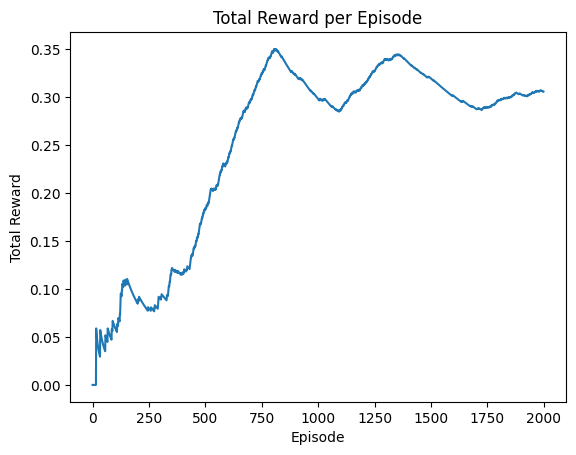

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
#좌표 (4,3), 목적지 직전 상태에서 수행하는 최적 행동 확인
print("What is the best move when i'm on 15?")
my_Action = np.argmax(Q[14])

if my_Action==0:
  print("Left")

elif my_Action==1:
  print("Down")

elif my_Action==2:
  print("Right")

else: print("up")

simulate_policy(env, Q)

What is the best move when i'm on 15?
Left
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


**2.** **e-greedy 방법의 SARSA**

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("FrozenLake-v2", is_slippery=True)

Q = np.zeros((env.observation_space.n, env.action_space.n))

num_episodes = 2000
alpha = 0.9
discount_factor = 0.9
epsilon = 1.0
epsilon_decay = 0.001

total_reward = []
total_reward_sum = []

for i in range(num_episodes):
    state = env.reset()
    done = False
    reward_sum = 0

    # 초기 행동 선택 (SARSA는 state, action 쌍으로 시작)
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])

    while not done:
        # 행동 실행
        new_state, reward, done, _ = env.step(action)

        # 다음 행동 선택
        if np.random.rand() < epsilon:
            new_action = env.action_space.sample()
        else:
            new_action = np.argmax(Q[new_state])

        # SARSA 업데이트
        Q[state, action] += alpha * (
            reward + discount_factor * Q[new_state, new_action] - Q[state, action]
        )

        reward_sum += reward
        state = new_state
        action = new_action  # 다음 step을 위해 action 업데이트

    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward) / (i + 1))
    epsilon = max(epsilon - epsilon_decay, 0)

In [ ]:
#성공률과 Q-table 값
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.355
Final Q-Table Values
[[1.39298985e-05 1.50500188e-05 5.23400696e-02 1.56038693e-05]
 [6.85119603e-06 2.50512638e-06 4.60785024e-06 5.24752064e-03]
 [4.54575609e-06 3.97852207e-06 4.63954957e-06 2.22769532e-03]
 [9.12558464e-07 4.95189196e-08 6.86989066e-07 3.68526672e-04]
 [1.04002377e-01 3.99877695e-06 6.26800689e-06 2.08299413e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.97705783e-08 4.71480566e-09 1.74114100e-03 1.84692685e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.35413551e-06 5.82010726e-06 3.27176417e-06 9.97040089e-02]
 [7.84742740e-06 1.85189158e-01 5.19271174e-06 3.33438732e-06]
 [1.62312922e-02 6.11970853e-07 6.03345763e-07 1.02853605e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.08283344e-04 7.45090358e-03 3.77034981e-01 8.51644824e-03]
 [1.82493468e-02 2.38719334e-02 5.79924311e-02 7.50929891e-03]
 [0.00000000e+

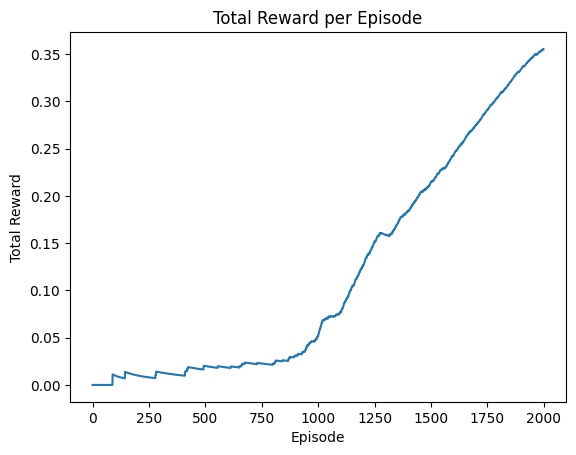

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
#좌표 (4,3), 목적지 직전 상태에서 수행하는 최적 행동 확인
print("What is the best move when i'm on 15?")
my_Action = np.argmax(Q[14])

if my_Action==0:
  print("Left")

elif my_Action==1:
  print("Down")

elif my_Action==2:
  print("Right")

else: print("up")

simulate_policy(env, Q)

What is the best move when i'm on 15?
Right
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


#(Additional Work) Customize Frozen Lake



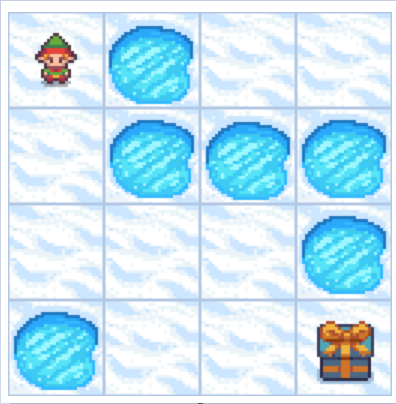

In [ ]:
#지금까진 모두 동일한 Hole 형태의 환경을 진행
#이번엔 시작 지점, 도착 지점, 구멍의 위치를 직접 설정하여 학습 진행
#S(start) = 시작점, H(hole) = 구멍, F(field)= 평지, G(goal) = 목적지
mydesc=["SHFF", "FHHH", "FFFH", "HFFG"]

In [ ]:
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False, 'desc': mydesc}
)

In [ ]:
import gym
from gym import wrappers
import numpy as np

env = gym.make("FrozenLake-v3")
env = wrappers.Monitor(env, "./results", force=True)

Q = np.zeros([env.observation_space.n, env.action_space.n])

num_episodes = 2000
discount_factor = 0.99
alpha = 0.9

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()
    reward_sum = 0
    done = False
    action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

    while not done:
        new_state, reward, done, _ = env.step(action)
        new_action = np.argmax(Q[new_state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * Q[new_state, new_action] - Q[state, action])
        reward_sum += reward
        state = new_state
        action = new_action
    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))


In [ ]:
#성공률과 Q-table 값
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.887
Final Q-Table Values
[[0.         0.95099005 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.96059601 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.970299   0.        ]
 [0.         0.9801     0.         0.        ]
 [0.         0.88209    0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.99       0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]]


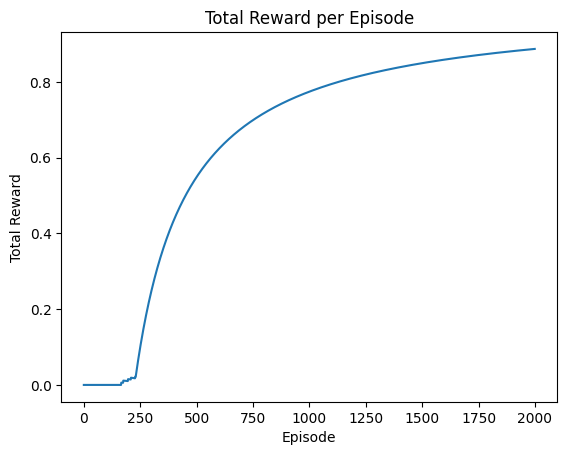

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
#좌표 (4,3), 목적지 직전 상태에서 수행하는 최적 행동 확인
print("What is the best move when i'm on 15?")
my_Action = np.argmax(Q[14])

if my_Action==0:
  print("Left")

elif my_Action==1:
  print("Down")

elif my_Action==2:
  print("Right")

else: print("up")

simulate_policy(env, Q)

What is the best move when i'm on 15?
Right
  (Down)
SHFF
FHHH
FFFH
HFFG
  (Down)
SHFF
FHHH
FFFH
HFFG
  (Right)
SHFF
FHHH
FFFH
HFFG
  (Down)
SHFF
FHHH
FFFH
HFFG
  (Right)
SHFF
FHHH
FFFH
HFFG
  (Right)
SHFF
FHHH
FFFH
HFFG


In [ ]:
register(
    id='FrozenLake-v4',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '8x8',
            'is_slippery': False}
) #기존 4x4 대신 8x8 환경 설정. 이에 따라 Q-table의 크기도 64x4 = 256으로 증가

In [ ]:
import gym
from gym import wrappers
import numpy as np

env = gym.make("FrozenLake-v4")
env = wrappers.Monitor(env, "./results", force=True)

Q = np.zeros([env.observation_space.n, env.action_space.n])

num_episodes = 2000
discount_factor = 0.99
alpha = 0.9

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()
    reward_sum = 0
    done = False
    action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

    while not done:
        new_state, reward, done, _ = env.step(action)
        new_action = np.argmax(Q[new_state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * Q[new_state, new_action] - Q[state, action])
        reward_sum += reward
        state = new_state
        action = new_action
    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))


In [ ]:
#성공률과 Q-table 값
print("Success rate: " + str(sum(total_reward) / num_episodes))
print("Final Q-Table Values")
print(Q)

Success rate: 0.623
Final Q-Table Values
[[0.         0.         0.87752102 0.        ]
 [0.         0.         0.88638487 0.        ]
 [0.         0.         0.89533825 0.        ]
 [0.         0.         0.90438208 0.        ]
 [0.         0.         0.91351725 0.        ]
 [0.         0.92274469 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.81055267 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.68950347]
 [0.         0.         0.93206535 0.        ]
 [0.         0.         0.94148015 0.        ]
 [0.         0.95099005 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.    

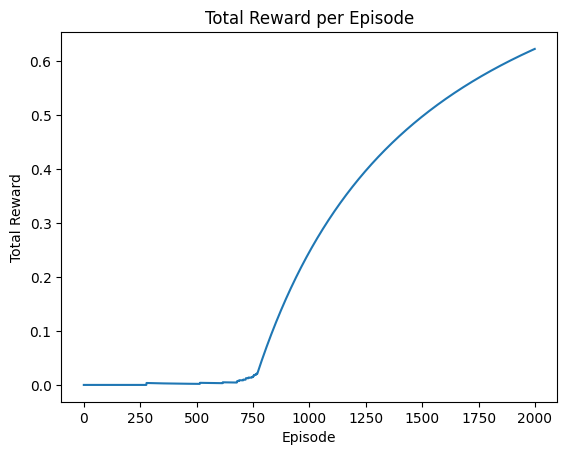

In [ ]:
# 에피소드별 성공, 실패 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
simulate_policy(env, Q)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFF

#실험환경: Taxi Environment

사용은.. e-greedy sarsa, e-greedy q-learning으로 두 번 진행.

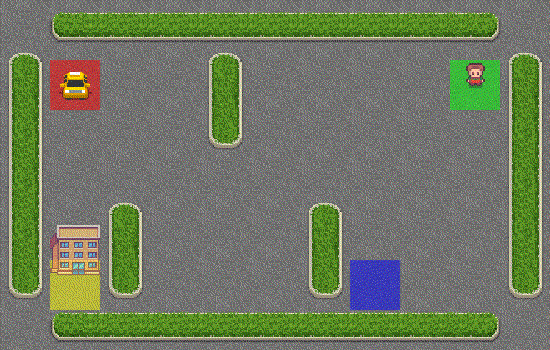

조금 더 복잡한 환경인 Taxi 환경에서 실험 진행

상태는 총 500개로, 25개의 택시 위치, 5개의 승객 위치, 4개의 도착지로 정의

행동은 총 6개로, 상하좌우 4개 + 승객 탑승 + 승객 하차 로 정의

에피소드는 승객이 택시에서 내리는 경우 종료

보상은 다음과 같음

1. timestep에 따라 -1
2. 정확한 위치에 승객을 하차시킬 경우 +20
3. 올바르지 않은 위치에서 승객 탑승 또는 하차시 -10

**목표: 낭비 없이 승객의 위치로 이동 후 탑승, 이후 알맞는 목적지에 승객 하차.**

**1.** **Q-러닝 + e-greedy**

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr

env = gym.make("Taxi-v3")
env.reset()

Q = np.zeros((env.observation_space.n, env.action_space.n))

num_episodes= 2000
alpha = 0.9
discount_factor = 0.9

epsilon = 1.0
epsilon_decay = 0.001   #이번엔 epsilon 값의 감소 방법을 일정하게 정한 scale만큼 지속적으로 감소시키도록 진행

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()
    reward_sum = 0
    done = False

    while not done:

        if np.random.random(1) < epsilon:
          action = env.action_space.sample()
        else:
          action = np.argmax(Q[state])
        new_state, reward, done, info = env.step(action)

        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state]) - Q[state, action])

        reward_sum += reward
        state = new_state

    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))

    #이번엔 epsilon 값의 감소 방법을 일정하게 정한 scale만큼 지속적으로 감소시키도록 진행
    epsilon = max(epsilon - epsilon_decay, 0)


In [ ]:
#성공률과 Q-table 값
print("Final Q-Table Values")
print(Q)

In [ ]:
# 에피소드별 보상 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
simulate_policy(env, Q)

**2.** **SARSA + e-greedy**

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr

env = gym.make("Taxi-v3")

Q = np.zeros((env.observation_space.n, env.action_space.n))

num_episodes= 2000
alpha = 0.9
discount_factor = 0.9

epsilon = 1.0
epsilon_decay = 0.001

total_reward = []
total_reward_sum = []
for i in range(num_episodes):
    state = env.reset()
    reward_sum = 0
    done = False
    action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))

    while not done:
        new_state, reward, done, _ = env.step(action)

        if np.random.random(1) < epsilon:
          new_action = env.action_space.sample()
        else:
          new_action = np.argmax(Q[state])
        new_state, reward, done, info = env.step(action)

        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * Q[new_state, new_action] - Q[state, action])
        reward_sum += reward
        state = new_state
        action = new_action

    total_reward.append(reward_sum)
    total_reward_sum.append(sum(total_reward)/(i+1))
    epsilon = max(epsilon - epsilon_decay, 0)

In [ ]:
#성공률과 Q-table 값
print("Final Q-Table Values")
print(Q)

In [ ]:
# 에피소드별 보상 그래프 출력
plt.figure()
plt.plot(total_reward_sum)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
simulate_policy(env, Q)